In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pymongo
from six import StringIO
import re
import seaborn as sns
import plotly
import requests



In [3]:
def remove_alphabets(value: str):
    if isinstance(value, str):
        result = re.findall(r'^[0-9]+', value)
        return result[0] if result else '0'
    return value

In [5]:

def read_http(http_url):
    response = requests.get(http_url)
    content = response.text
    content = content.replace("\t", ",").replace(",:", ",0")
    return pd.read_csv(StringIO(content), delimiter=",")

In [6]:
# Read and transform data

df = read_http("https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/urb_cecfi?format=TSV")

df = df.rename(columns={"cities\\TIME_PERIOD": "city"})
df = df.drop("freq", axis=1)
df_melted = df.melt(id_vars=['indic_ur', 'city'], var_name='year', value_name='enterprises')
df_melted["enterprises"] = df_melted["enterprises"].apply(remove_alphabets)
df_melted["year"] = pd.to_numeric(df_melted["year"].apply(lambda year: year.strip()))
df_melted["country"] = df_melted["city"].apply(lambda city: city[:2])
df_melted = df_melted[df_melted["enterprises"] != "0"]
df_melted["enterprises"] = pd.to_numeric(df_melted["enterprises"])


In [10]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
apdv_db = client["APDV"]
collection = apdv_db["enterprises"]

df_without_index = df_melted.reset_index()
data_dict = df_without_index.to_dict("records")
collection.insert_many(data_dict)

InsertManyResult([ObjectId('67f05ddc101ca43e73e780e3'), ObjectId('67f05ddc101ca43e73e780e4'), ObjectId('67f05ddc101ca43e73e780e5'), ObjectId('67f05ddc101ca43e73e780e6'), ObjectId('67f05ddc101ca43e73e780e7'), ObjectId('67f05ddc101ca43e73e780e8'), ObjectId('67f05ddc101ca43e73e780e9'), ObjectId('67f05ddc101ca43e73e780ea'), ObjectId('67f05ddc101ca43e73e780eb'), ObjectId('67f05ddc101ca43e73e780ec'), ObjectId('67f05ddc101ca43e73e780ed'), ObjectId('67f05ddc101ca43e73e780ee'), ObjectId('67f05ddc101ca43e73e780ef'), ObjectId('67f05ddc101ca43e73e780f0'), ObjectId('67f05ddc101ca43e73e780f1'), ObjectId('67f05ddc101ca43e73e780f2'), ObjectId('67f05ddc101ca43e73e780f3'), ObjectId('67f05ddc101ca43e73e780f4'), ObjectId('67f05ddc101ca43e73e780f5'), ObjectId('67f05ddc101ca43e73e780f6'), ObjectId('67f05ddc101ca43e73e780f7'), ObjectId('67f05ddc101ca43e73e780f8'), ObjectId('67f05ddc101ca43e73e780f9'), ObjectId('67f05ddc101ca43e73e780fa'), ObjectId('67f05ddc101ca43e73e780fb'), ObjectId('67f05ddc101ca43e73e780

In [ ]:
countries_all_enterprises = df_melted[(df_melted["year"] == 1998)].groupby(by="country").agg({'enterprises': 'sum'})

sns.barplot(countries_all_enterprises.sort_values(by="enterprises", ascending=True).tail(10)[::-1], x="country",
            y="enterprises").set_title("Number of enterprises in top european countries in 1998")
plt.show()

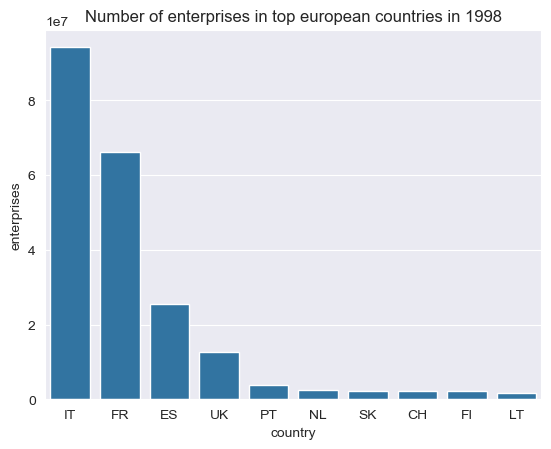

In [55]:
countries_local_enterprises = df_melted[df_melted["indic_ur"] == "EC2039V"].groupby(by="country").agg(
    {'enterprises': 'sum'})

sns.barplot(countries_local_enterprises.sort_values(by="enterprises", ascending=True).tail(10)[::-1], x="country",
            y="enterprises").set_title("Number of enterprises in top european countries in 1998")
plt.show()

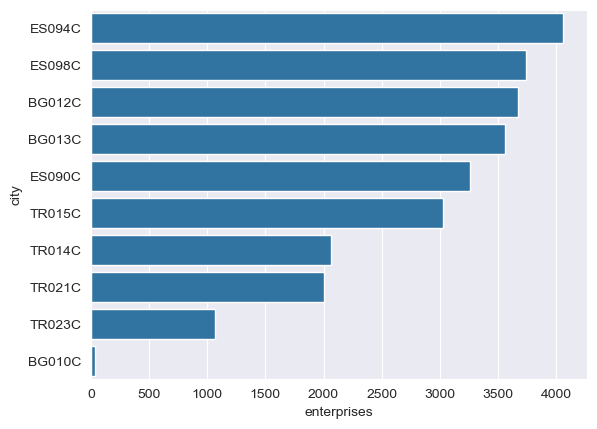

In [56]:

city_all_enterprises = df_melted.groupby(by="city").agg({'enterprises': 'sum'})

top_cities_with_most_companies = city_all_enterprises.sort_values(by="enterprises", ascending=True).head(10)
sns.barplot(top_cities_with_most_companies.iloc[::-1], y = "city", x = "enterprises")
plt.show()

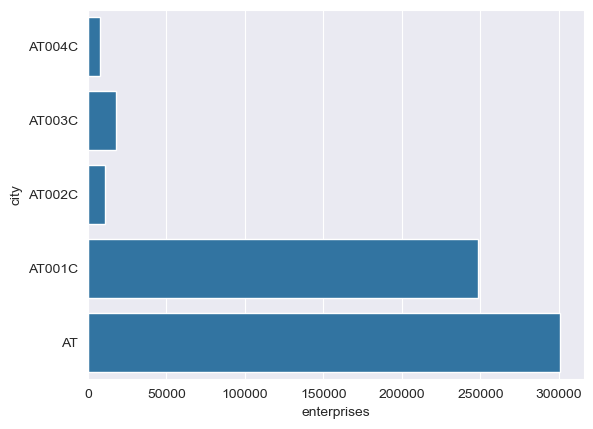

In [57]:
city_all_enterprises = df_melted[df_melted["indic_ur"] == "EC2021V"].groupby(by="city").agg({'enterprises': 'sum'}).head()
sns.barplot(city_all_enterprises.iloc[::-1], y = "city", x = "enterprises")
plt.show()


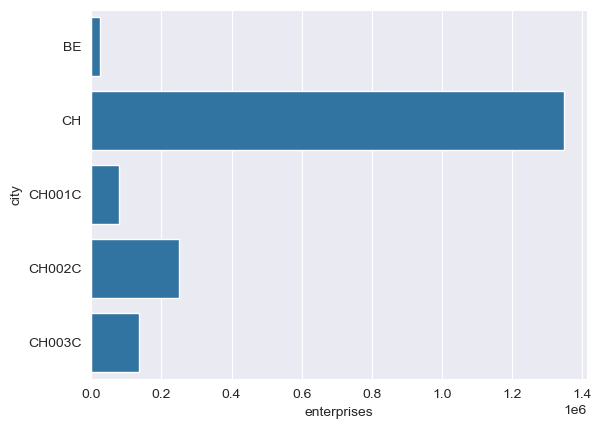

In [58]:
city_local_enterprises = df_melted[df_melted["indic_ur"] == "EC2039V"].groupby(by="city").agg({'enterprises': 'sum'}).head()
sns.barplot(city_local_enterprises, y = "city", x = "enterprises")
plt.show()


In [59]:
import plotly.express as px

top_cities_with_most_local_companies = city_local_enterprises.sort_values(by="enterprises", ascending=False).head(10)
# sns.barplot(top_cities_with_most_local_companies.iloc[::-1], y = "city", x = "enterprises")
# plt.show()
# Create interactive line chart
top_cities_with_most_local_companies.reset_index(inplace=True)
fig = px.line(top_cities_with_most_local_companies.iloc[::-1], x="city", y = "enterprises", title="Yearly Business trend", markers=True)

# Show the chart
fig.show()

['BE' 'CY' 'DE' 'FI' 'HU' 'IT' 'LT' 'LU' 'MT' 'PL' 'PT' 'RO' 'SE' 'SI'
 'SK' 'UK' 'AT' 'BG' 'CH' 'CZ' 'DK' 'EE' 'EL' 'ES' 'FR' 'HR' 'LV' 'NL'
 'NO' 'TR']


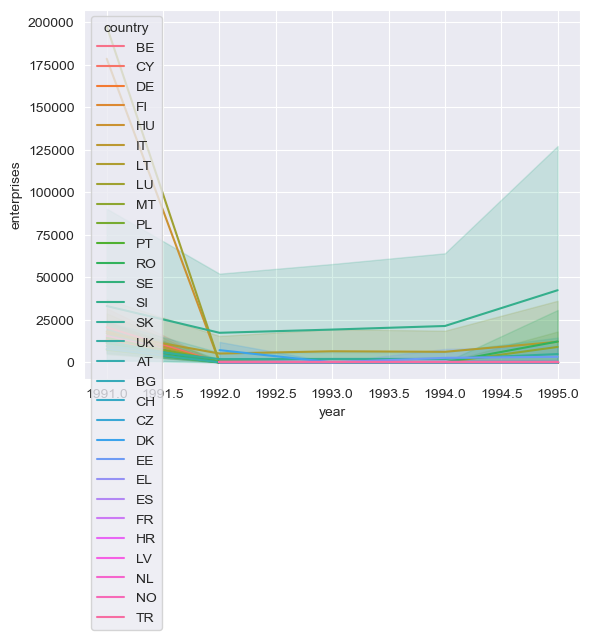

In [60]:

print(df_melted["country"].unique())
# ireland = df_melted[df_melted["country"] == "FR"]
# ireland = ireland[ireland["year"] > 2015]
# print(ireland.columns)
sns.lineplot(df_melted.head(5000), y = "enterprises", x = "year", hue="country")
plt.show()

In [61]:
# pie  chart



In [62]:
import plotly.express as px
import pandas as pd


# Create interactive line chart
fig = px.line(df_melted, x="year", y="enterprises", title="Yearly Business trend", markers=True)

# Show the chart
fig.show()
